Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-2-59159283ca4a>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['Label'] = combined_df['Activity'].apply(lambda x: 0 if x in ['Normal', 'BENIGN'] else 1)


Classification Report (Selected 13 Features + SMOTE):
              precision    recall  f1-score   support

           0       0.96      0.93      0.94     10392
           1       0.93      0.96      0.95     10392

    accuracy                           0.94     20784
   macro avg       0.94      0.94      0.94     20784
weighted avg       0.94      0.94      0.94     20784



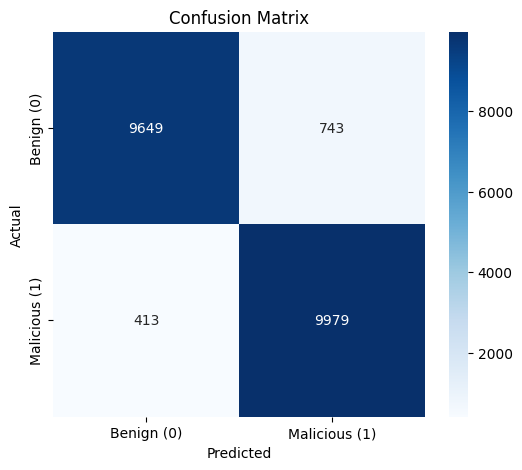

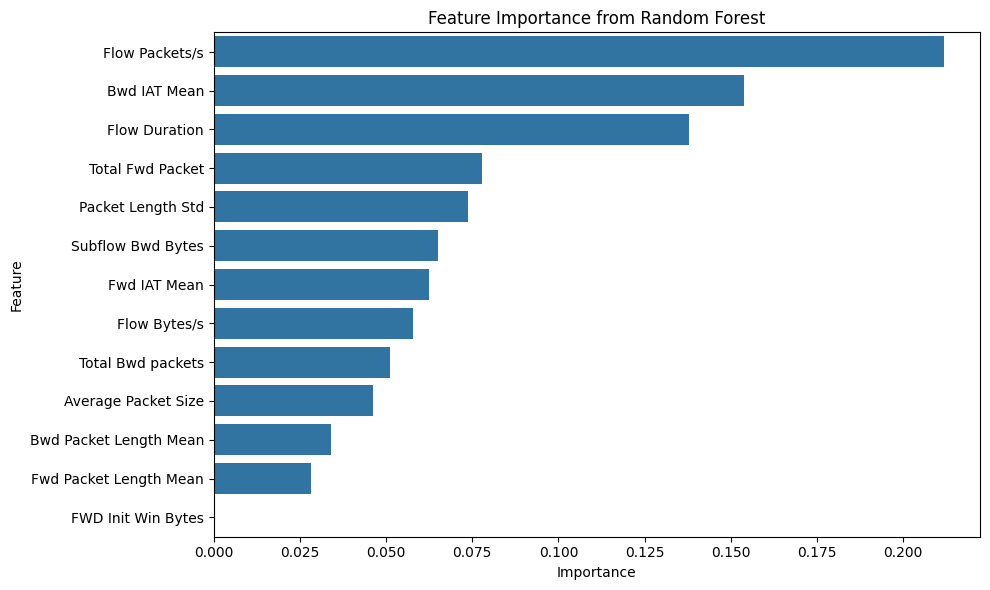

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib
from google.colab import drive, files

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Set path to the folder
csv_dir = "/content/drive/MyDrive/Dataset-APT2025"

# Step 3: Load all CSV files
csv_files = [f for f in os.listdir(csv_dir) if f.endswith(".csv")]

dataframes = []
for file in csv_files:
    df = pd.read_csv(os.path.join(csv_dir, file))
    df['source_file'] = file
    dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)

# Step 4: Label encoding from 'Activity'
combined_df = combined_df.dropna(subset=['Activity'])
combined_df['Label'] = combined_df['Activity'].apply(lambda x: 0 if x in ['Normal', 'BENIGN'] else 1)

# Step 5: Select 13 manually chosen features
selected_features = [
    'Flow Duration',
    'Total Fwd Packet',
    'Total Bwd packets',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Fwd Packet Length Mean',
    'Bwd Packet Length Mean',
    'Fwd IAT Mean',
    'Bwd IAT Mean',
    'Average Packet Size',
    'Packet Length Std',
    'Subflow Bwd Bytes',
    'FWD Init Win Bytes'
]

# Ensure all selected features exist
selected_features = [f for f in selected_features if f in combined_df.columns]

X = combined_df[selected_features].replace([np.inf, -np.inf], np.nan).fillna(0)
y = combined_df['Label']

# Step 6: Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 7: Handle class imbalance using SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_scaled, y)

# Step 8: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Step 9: Train the model without redundant balancing (SMOTE already applied)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 10: Evaluate the model
y_pred = model.predict(X_test)
print("Classification Report (Selected 13 Features + SMOTE):")
print(classification_report(y_test, y_pred))

# Step 11: Visualize Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Benign (0)', 'Malicious (1)']
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 12: Feature Importance
importances = model.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': selected_features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Feature Importance from Random Forest')
plt.tight_layout()
plt.show()

# Step 13: Save model and scaler
joblib.dump(model, "rf_model.pkl")
joblib.dump(scaler, "scaler.pkl")

# Step 14: Download files
files.download("rf_model.pkl")
files.download("scaler.pkl")
